In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

2024-05-01 16:24:11.130370: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 16:24:11.130814: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 16:24:11.133593: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 16:24:11.168139: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 16:24:11.768468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
def build_lenet5():
     ##LeNet requires to have input 32x32 based on its architecture
    model = models.Sequential()
    model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 1))) # first layer of network, that contains 6 filters with 5x5 with activation function ReLU - which introduces non-linearity to the model helping it to learn more complex patterns in the data
    model.add(layers.AveragePooling2D(pool_size=(2,2))) # pooling layer to reduce the dimension - it should make the position of object in the picture less relevant
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.AveragePooling2D(pool_size=(2,2)))
    model.add(layers.Flatten()) # transforms 2D matrix into 1D vector to connect convolutional layers with dense layers
    model.add(layers.Dense(120, activation='relu')) # 120 neurons 
    model.add(layers.Dense(84, activation='relu')) # 84 neurons
    model.add(layers.Dense(10, activation='softmax')) # softmax outputs the probabilities for each class
    return model

In [3]:
lenet5_model = build_lenet5()
lenet5_model.summary()

/home/luky/playground/handwriting_recognition/lenet5/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-01 16:24:13.293926: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 16:24:13.294429: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/inst

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


train_images = tf.pad(train_images, [[0, 0], [2, 2], [2, 2]])
train_images = tf.cast(train_images, tf.float32) / 255.0
test_images = tf.pad(test_images, [[0, 0], [2, 2], [2, 2]])
test_images = tf.cast(test_images, tf.float32) / 255.0

train_images = 1.0 - train_images # to revert colors to train the network 

train_images.shape

TensorShape([60000, 32, 32])

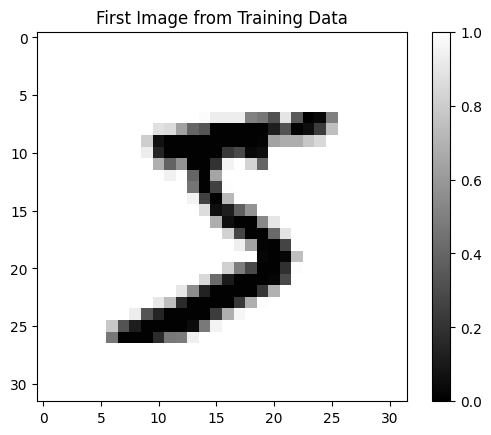

In [5]:

# Plotting the image
plt.imshow(train_images[0, :, :], cmap='gray')  # 'cmap' specifies that we want to see the image in grayscale
plt.title('First Image from Training Data')
plt.colorbar()
plt.show()


In [6]:


train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)


#create batches
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)  # Shuffle and batch the data
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32)  # Only batch the test data (no need to shuffle)


In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [8]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

In [9]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = lenet5_model(images,training = True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, lenet5_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lenet5_model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [10]:
epochs = 5

for epoch in range(epochs):
    train_loss.reset_state()
    train_accuracy.reset_state()

    for images, labels in train_dataset:
        train_step(images, labels)
        
    print(f'Epoch {epoch + 1}, '
          f'Loss: {train_loss.result()}, '
          f'Accuracy: {train_accuracy.result() * 100}')

2024-05-01 16:25:11.330945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Loss: 0.2303648591041565, Accuracy: 93.02166748046875


2024-05-01 16:26:08.380600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 0.07447586208581924, Accuracy: 97.65499877929688


2024-05-01 16:27:05.803129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Loss: 0.05321693420410156, Accuracy: 98.36666870117188


2024-05-01 16:28:03.272229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Loss: 0.041382160037755966, Accuracy: 98.68000030517578
Epoch 5, Loss: 0.03418348357081413, Accuracy: 98.91500091552734


2024-05-01 16:29:00.494359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
lenet5_model.save("lenet5_model.keras")